# Bayesian Parameter Estimation on MBL Data
# Using a hierarchical model
## Allow for multiple strain datasets, but lump multiple days
## Nathan Belliveau, Griffin Chure, Manuel Razo
**July 16, 2016**

In [1]:
import numpy as np
import pandas as pd
import emcee
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns
import scipy.stats as sc #import multivariate_normal
import mwc_induction_utils as mwc
import corner
rc = {'lines.linewidth': 1.5,
      'axes.labelsize' : 14,
      'axes.titlesize' : 18,
      'axes.facecolor' : 'EBEBEB',
      'axes.edgecolor' : '000000',
      'axes.linewidth' : 0.75,
      'axes.frameon' : True,
      'xtick.labelsize' : 11,
      'ytick.labelsize' : 11,
      'font.family' : 'Droid Sans',
      'grid.linestyle' : ':',
      'grid.color' : 'a6a6a6',
      'mathtext.fontset' : 'stixsans',
      'mathtext.sf' : 'sans'}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans') 
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#------------------------------------------------------------------------------- 
%matplotlib notebook

/Users/Nathan/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/Nathan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Following Manuel's hierachical model, we want to calculate the following posterior:

\begin{equation}
P(\mathbf{Q}, \kappa \mid D, I) \propto \prod_{i = 1}^n P(d_i \mid \mathbf{K}_i, I) \cdot P(\kappa \mid \mathbf{Q}, I) \cdot P(\mathbf{Q} \mid I).
\end{equation}

For ease, note that $P(\kappa \mid \mathbf{Q}, I)$ has marginalized out $\mathbf{K}_i$, so lets take it out of the multiplication.

\begin{equation}
P(\mathbf{Q}, \kappa \mid D, I) \propto P(\kappa \mid \mathbf{Q}, I)^N \prod_{i = 1}^n P(d_i \mid \mathbf{K}_i, I) \cdot P(\mathbf{Q} \mid I).
\end{equation}

The log posterior is then,

\begin{equation}
log( P(\mathbf{Q}, \kappa \mid D, I) ) \propto N \cdot log( P(\kappa \mid \mathbf{Q}, I) ) + \sum_{i = 1}^n log( P(d_i \mid \mathbf{K}_i, I) ) + log( P(\mathbf{Q} \mid I) ).
\end{equation}



This posterior is  our **full hierarchical model**. See 20160710_hierarchical_model.ipynb for each term. For now I will lump the multiple datasets from each strain together.

Load in the data:

In [2]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')

In [3]:
# To pass in each strain dataset, I generate arrays containing 
# the IPTG concentration and fold-change values.
# I'm sure this can be done in a more clever way.

rbs_delta = data[(data.strain=='delta') & (data.epsilon_r==-13.9)]
rbs_104 = data[(data.strain=='104') & (data.epsilon_r==-13.9)]
rbs_1147 = data[(data.strain=='1147') & (data.epsilon_r==-13.9)]
rbs_446 = data[(data.strain=='446') & (data.epsilon_r==-13.9)]
rbs_1027 = data[(data.strain=='1027') & (data.epsilon_r==-13.9)]
rbs_1L = data[(data.strain=='1L') & (data.epsilon_r==-13.9)]
rbs_rbs1 = data[(data.strain=='rbs1') & (data.epsilon_r==-13.9)]

# If only using a single strain's data, pass in to emcee like
# rbs_IPTG[1], rbs_fc[1], and R[1]

rbs_IPTG = [ rbs_delta.IPTG, rbs_104.IPTG, rbs_1147.IPTG, rbs_446.IPTG, \
            rbs_1027.IPTG, rbs_1L.IPTG, rbs_rbs1.IPTG ]
rbs_fc = [rbs_delta.fold_change, rbs_104.fold_change, rbs_1147.fold_change, \
          rbs_446.fold_change, rbs_1027.fold_change, rbs_1L.fold_change, \
          rbs_rbs1.fold_change]

# R is an array containing the copy number of each strain.
R = [ 0, 11, 30, 62, 130, 610, 870]

## Defining the log posterior

Below, we define the functions needed to perform our parameter estimation. 

In [4]:
def log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai):
    """
    Computes the log likelihood.
    """
    #Unpack the parameters.
    ea = param[:len(R)]
    ei = param[len(R):-5]
    Q = param[-5:-3]
    sigma_Ks = [param[-3],param[-2],param[-1]]
    # Sigma_Ks are the sigma parameters for the bi-variate gaussian. 
    # We need to reshape to a 2x2 array. 
    sigma_K_reshape = [[sigma_Ks[0], sigma_Ks[2]],[sigma_Ks[2], sigma_Ks[1]] ]
    
    # Use arbitrary fold-change sigma for now.
    sigma = 0.01
    
    # We need to sum over all strains
    # Set log likelihood to zero
    log_like = 0
    
    # This is the multivariate prior term.
    # Sum over all strains.
    for i in range(0,len(R)):
        log_like = log_like + len(R)*np.log(sc.multivariate_normal.pdf([ea[i],ei[i]] , Q, sigma_K_reshape ))
    
    # This is the fold-change term.
    # Sum over all strains.
    for i in range(0,len(R)):#len(R)):      
        fc_theo = mwc.fold_change_log(IPTG[i], ea[i], ei[i], ep_ai, R[i], ep_r) 
        log_like = log_like + len(IPTG[i])*np.log(sigma) - np.sum((fc[i]-fc_theo)**2) / 2 / sigma**2
    return log_like    
   
        
           
def log_post_log(param, IPTG, fc, R, ep_r, ep_ai):
    ea = param[:len(R)]
    ei = param[len(R):-5]
    Q = param[-5:-3]
    sigma_Ks = [param[-3],param[-2],param[-1]]
    sigma_K_reshape = [[sigma_Ks[0], sigma_Ks[2]],[sigma_Ks[2], sigma_Ks[1]] ]
    
    # Check that the parameters satisfy our priors 
    # I'm sure this can be done with less loops, but 
    # my previous approach was giving me problems.
    for i in range(0,len(R)):
        if ea[i] < 0 or ea[i] > 10:
            return -np.inf
        if ei[i] < 0 or ei[i] > 10:
            return -np.inf
    for i in range(0,2):
        if Q[i] < 0 or Q[i] > 10:
            return -np.inf
        if sigma_Ks[i] > 10 or sigma_Ks[i] < 0:
            return -np.inf
    
    # Check sigma cov matrix is positive definite
    # This might be necessary when the off diagonal values
    # are not equal to zero.
    
    def is_pos_def(x):
        return np.all(np.linalg.eigvals(x) > 0)

    if (is_pos_def(sigma_K_reshape) != 1):
        return -np.inf
    
    return log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai)

In [5]:
# Define the parameters for emcee
# Number of dimensions is #strains**2 for each ea and ei + (Qa and Qe) + sigma_A, sigma_I, and sigma_AI 
n_dim = 2*len(R) + 2 + 3 
n_walkers = 2*n_dim
n_burn = 5000
n_steps = 1000 

# Initialize random parameters for each
p0 = np.empty((n_walkers, n_dim))
p0[:,:len(R)] = np.random.uniform(0, 5,[n_walkers, len(R)])
p0[:,len(R):-5] = np.random.uniform(0, 10, [n_walkers, len(R)])
p0[:,-5] = np.random.uniform(1, 4.5, n_walkers)
p0[:,-4] = np.random.uniform(6, 9, n_walkers)
p0[:,-3:-1] = np.random.uniform(0, 5, [n_walkers, 2])
p0[:,-1] = np.random.uniform(0, 5, n_walkers)


In [6]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_log,\
                args=(rbs_IPTG, rbs_fc, R, -13.9, 4.5),\
                threads=6)

In [7]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [8]:
_ = sampler.run_mcmc(pos, n_steps)

# Now let's take a lok at the results.

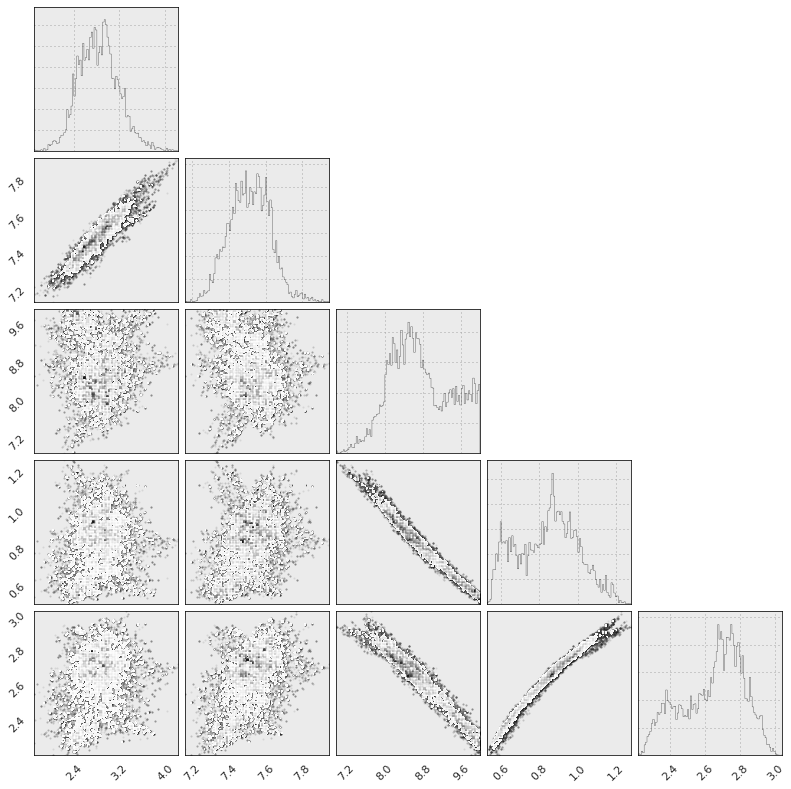

In [20]:
# Let's plot some of the parameter values
fig = corner.corner(sampler.flatchain[:,-5:], bins=100, plot_contours=False)

In [24]:
# let's set ea and ei to the Qa and Qi values we found
ea = np.mean(sampler.flatchain[:, 4])
ei = np.mean(sampler.flatchain[:, len(R)+4])

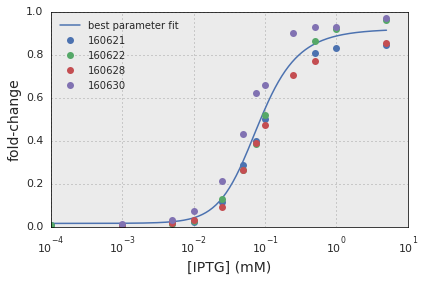

In [25]:
#lets take a look at fit with 1027 data
IPTG = np.logspace(-4, np.log10(5), 200)
fc_theory = mwc.fold_change_log(IPTG, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '-b', label='best parameter fit')
for date in rbs_1027.date.unique():
    plt.plot(rbs_1027[rbs_1027.date==date].IPTG, rbs_1027[rbs_1027.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

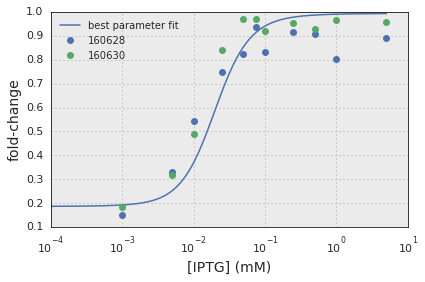

In [26]:
#lets take a look at fit with HG104 data
IPTG = np.logspace(-4, np.log10(5), 200)
fc_theory = mwc.fold_change_log(IPTG, ea, ei, 4.5, R=10, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '-b', label='best parameter fit')
for date in rbs_104.date.unique():
    plt.plot(rbs_104[rbs_104.date==date].IPTG, rbs_104[rbs_104.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

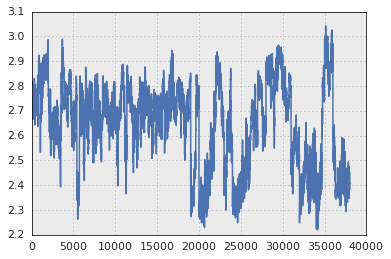

In [27]:
# let's look at some of the traces to make sure things look okay
# I probably shoudl run longer from the looks of it.
%matplotlib inline
plt.plot(sampler.flatchain[:, -1])
#plt.ylim(2,4)

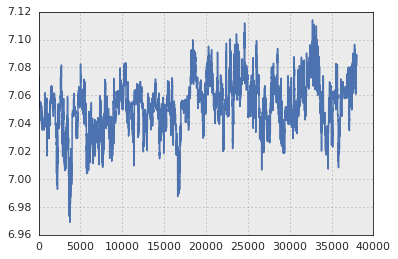

In [15]:
plt.plot(sampler.flatchain[:, len(R)+2])
#plt.ylim(5,10)

In [ ]:
# Print results for Q
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} mM
Ki = {1:.5f} mM
""".format(np.exp(-ea), np.exp(-ei)))

#aside: this is what was found with only 1027 data:
#Ka = 0.21 mM
#Ki = 0.00087 mM

In [98]:
#ignore following

-1.5141277326297755

In [63]:
temp = np.array([0,1,2,1,0])

In [67]:
if np.any(temp > 0):
    print('works')

works


In [ ]:
N_strains = data.groupby('strain').IPTG.nunique()
IPTG_conc = data.groupby('strain').IPTG.unique()
R = data.groupby('strain').repressors.unique()#.values

